In [19]:
import pandas as pd
import matplotlib.pylab as plt
import urllib.request, json 
from datetime import datetime
import numpy as np
from tqdm import tqdm
import itertools
%matplotlib widget
FILENAME = 'https://covid19.compute.dtu.dk/data/telco_map_new.json'

# Directed data

In [2]:
FILENAME = 'https://covid19.compute.dtu.dk/data/telco_data.json'
with urllib.request.urlopen(FILENAME) as url:
    rawdata = json.loads(url.read().decode())

In [63]:
data = np.array(rawdata['data'])
locations = rawdata['locations']
dates = [datetime.fromisoformat(d) for d in rawdata['dates']]

  - data     : num [1:9604, 1:516] 323162 405 0 0 690 ...
  - locations: chr [1:98] "Aabenraa" "Aalborg" "Albertslund" "Allerød" ...
  - dates    : chr [1:516] "2020-02-01 00:00:00" "2020-02-02 00:00:00" "2020-02-03 00:00:00" "2020-02-04 00:00:00" ...
  
`data` is a matrix with columns corresponding to dates and rows corresponding to each unique origin-destination combination (location[1] -> location[1], location[1] -> location[2], location[1] -> location[3] … location[2] -> location[1], location[2] -> location[2] …)

In [4]:
##ALL ORIGIN DESTINATION PAIRS
origin_destination_pairs = np.array(list(itertools.product(locations, repeat=2)))

##CONCATENATE WITH VALUES
all_data = np.concatenate([origin_destination_pairs, data], axis=1, dtype='object')

##BUILD DATAFRAME
columns = ['origin','destination']+[datetime.fromisoformat(date_string) for date_string in rawdata['dates']]
data_long = pd.DataFrame(all_data,columns=columns).set_index(['origin','destination']).stack().reset_index()
data_long.columns = ['origin','destination','date','counts']
data_long.head()

,origin,destination,date,counts
0,Aabenraa,Aabenraa,2020-02-01,323162.099102
1,Aabenraa,Aabenraa,2020-02-02,295328.638037
2,Aabenraa,Aabenraa,2020-02-03,388974.404547
3,Aabenraa,Aabenraa,2020-02-04,404667.087491
4,Aabenraa,Aabenraa,2020-02-05,407815.830703


In [5]:
fig, ax = plt.subplots(figsize = (10,4))
data_long[(data_long.origin=='København') & (data_long.destination=='Frederiksberg')].set_index('date').plot(ax=ax,legend=False)
data_long[(data_long.origin=='Frederiksberg') & (data_long.destination=='København')].set_index('date').plot(ax=ax,legend=False)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
num_locations = np.size(rawdata['locations'])
num_dates = np.size(dates)
data_3d = np.reshape(rawdata['data'], (num_locations, num_locations, num_dates))
np.shape(data_3d)

(98, 98, 516)

# Build the network on a specific date

In [7]:
from graph_tool import *
import graph_tool.inference as gi
import graph_tool.topology as gt
import graph_tool.draw as gd

In [8]:
def getedgelist(data_long, date):
    date_mask = data_long.date == date
    edgelist = data_long.loc[ date_mask, ["origin", "destination", "counts"] ]
    edgelist = edgelist.set_index(["origin", "destination"])
    #edgelist.counts /= np.sum(edgelist.counts)
    return edgelist
#edgelist = getedgelist(data_long, data_long.loc[1,"date"])
#edgelist.head()

In [9]:
def getgraph(locations):
    num_locations = np.size(locations)
    g = Graph(directed=True)
    g.add_vertex(num_locations)
    names = g.vertex_properties["names"] = g.new_vertex_property("string")
    for i in range(num_locations):
        names[i] = locations[i]
        for j in range(num_locations):
            if i != j:
                g.add_edge(i,j)
    
    g.edge_properties["flow"]         = g.new_edge_property("double")
    g.edge_properties["invflow"]      = g.new_edge_property("double")
    g.vertex_properties["totalflow"]  = g.new_vertex_property("double")
    g.edge_properties["localeffdist"] = g.new_edge_property("double")
    g.edge_properties["effdist"]      = g.new_edge_property("double")
    g.edge_properties["sp_flow"]      = g.new_edge_property("double")
    g.edge_properties["sp_invflow"]   = g.new_edge_property("double")
    return g
#g = getgraph(locations)

In [10]:
def addflow(g, edgelist, num_locations):
    mask    = g.new_edge_property("bool")
    names   = g.vertex_properties["names"]
    flow    = g.edge_properties["flow"] 
    invflow = g.edge_properties["invflow"]
    
    for i in range(num_locations):
        for j in range(i+1, num_locations):
            n = names[i]
            m = names[j]
            Fnm = edgelist.loc[(n,m),"counts"]
            Fmn = edgelist.loc[(m,n),"counts"]
            F = Fnm + Fmn
            if F != 0:
                for e in [g.edge(i,j), g.edge(j,i)]:
                    flow[e] = F
                    mask[e] = True
                    invflow[e] = 1/flow[e]
                
    g.set_edge_filter(mask)
    totalflow = g.vertex_properties["totalflow"]
    totalflow.a = g.get_out_degrees(range(num_locations), eweight=g.ep.flow)
    return
#addflow(g, edgelist, num_locations)

In [11]:
def filter_largest_component(g):
    LC = gt.label_largest_component(g, directed=False)
    g.set_vertex_filter(None)
    return
#filter_largest_component(g)

In [12]:
def add_local_effdist(g, edgelist, num_locations):
    local_effdist = g.edge_properties["localeffdist"]
    totalflow = g.vertex_properties["totalflow"]
    flow = g.edge_properties["flow"]
    for s in g.vertices():
        for e in s.out_edges():
            local_effdist[e] = 1 - np.log(flow[e]) + np.log(totalflow[s])
    return
#add_local_effdist(g, edgelist, num_locations)

In [13]:
def shortestdist(g):
    effdist       = g.ep.effdist
    sp_flow       = g.ep.sp_flow
    sp_invflow    = g.ep.sp_invflow
    
    all_effdist = gt.shortest_distance(g, weights=g.ep.localeffdist)
    all_sp_flow = gt.shortest_distance(g, weights=g.ep.flow)
    all_sp_invflow = gt.shortest_distance(g, weights=g.ep.invflow)
    
    for e in g.edges():
        s = e.source()
        t = e.target()
        effdist[e]    = all_effdist[s][t]
        sp_flow[e]    = all_sp_flow[s][t]
        sp_invflow[e] = all_sp_invflow[s][t]
    return
#shortestdist(g)

In [14]:
def meandist(g, eproperty):
    dists = g.edge_properties[eproperty]
    mean_dists = float( np.mean( [dists[e] for e in g.edges()] ) )
    return mean_dists

---

In [21]:
g = getgraph(locations)
num_dates = np.size(dates)
mean_effdists = np.zeros(num_dates)
mean_invflow  = np.zeros(num_dates)
mean_flow  = np.zeros(num_dates)
graphs = []
edgelists = []

for k in tqdm(range(0,num_dates)):
    edgelist = getedgelist(data_long, dates[k])
    addflow(g, edgelist, num_locations)
    filter_largest_component(g)
    add_local_effdist(g, edgelist, num_locations)
    shortestdist(g)
    
    mean_effdists[k] = meandist(g, "effdist")
    mean_invflow[k]  = meandist(g, "sp_invflow")
    mean_flow[k]     = meandist(g, "sp_flow")
    graphs.append(g)
    edgelists.append(edgelist)
    
    g.set_vertex_filter(None)
    g.set_edge_filter(None)

100%|██████████| 516/516 [08:46<00:00,  1.02s/it]


In [30]:
%matplotlib inline

In [35]:
dates[]

datetime.datetime(2021, 2, 5, 0, 0)

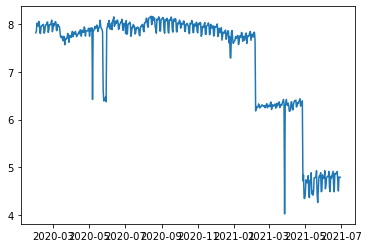

In [40]:
plt.plot(dates, mean_effdists)

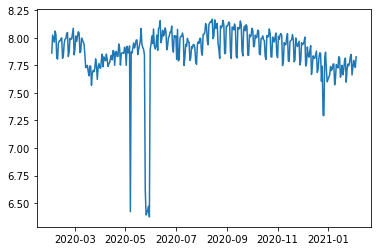

In [38]:
plt.plot(dates[1:370], mean_effdists[1:370])

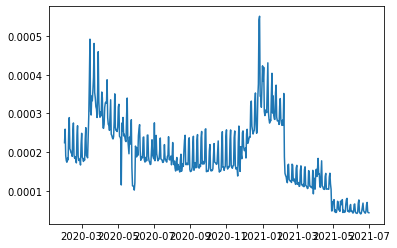

In [39]:
plt.plot(dates, mean_invflow)
plt.show()

In [66]:
df = data_long.copy()
df["effdist"] = np.NaN
df["shortespath"] = np.NaN
df = df.set_index(['origin','destination','date'])
df.head()

counts  effdist  shortespath
origin   destination date                                           
Aabenraa Aabenraa    2020-02-01  323162.099102      NaN          NaN
                     2020-02-02  295328.638037      NaN          NaN
                     2020-02-03  388974.404547      NaN          NaN
                     2020-02-04  404667.087491      NaN          NaN
                     2020-02-05  407815.830703      NaN          NaN

In [ ]:
names    = g.vertex_properties["names"]
effdist  = g.ep.effdist
shortest = g.ep.sp_invflow

for d in tqdm(dates):
    for (s,t) in g.iter_edges():
        n = names[s]
        m = names[t]
        e = g.edge(s,t)
        df.loc[(n,m,d), "effdist"] = effdist[e]
        df.loc[(n,m,d), "shortest"] = shortest[e]

  0%|          | 0/516 [00:00<?, ?it/s]